In [2]:
# Phase 4 - Step 1: Train-Test Split

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the final Phase 3 dataset
data = pd.read_csv('/Users/shubhmehta/Desktop/programming/Data Science Projects/Chronic kidney disease EHRs Abu Dhabi/data/phase3_features_final.csv')

# Features and target
X = data.drop(columns=['EventCKD35'])
y = data['EventCKD35']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Save the split data if needed
X_train.to_csv('/Users/shubhmehta/Desktop/programming/Data Science Projects/Chronic kidney disease EHRs Abu Dhabi/data/X_train.csv', index=False)
X_test.to_csv('/Users/shubhmehta/Desktop/programming/Data Science Projects/Chronic kidney disease EHRs Abu Dhabi/data/X_test.csv', index=False)
y_train.to_csv('/Users/shubhmehta/Desktop/programming/Data Science Projects/Chronic kidney disease EHRs Abu Dhabi/data/y_train.csv', index=False)
y_test.to_csv('/Users/shubhmehta/Desktop/programming/Data Science Projects/Chronic kidney disease EHRs Abu Dhabi/data/y_test.csv', index=False)

# Quick check
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Class distribution in y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in y_test:\n{y_test.value_counts(normalize=True)}")


Shape of X_train: (392, 8)
Shape of X_test: (99, 8)
Class distribution in y_train:
EventCKD35
0    0.885204
1    0.114796
Name: proportion, dtype: float64
Class distribution in y_test:
EventCKD35
0    0.888889
1    0.111111
Name: proportion, dtype: float64


In [3]:
# Phase 4 - Step 2: Apply SMOTE to the Training Set

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE ONLY on training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Quick check after SMOTE
print(f"Shape of X_train_smote: {X_train_smote.shape}")
print(f"Class distribution in y_train_smote:\n{y_train_smote.value_counts(normalize=True)}")

Shape of X_train_smote: (694, 8)
Class distribution in y_train_smote:
EventCKD35
0    0.5
1    0.5
Name: proportion, dtype: float64


In [4]:
# Phase 4 - Step 3: Train Logistic Regression (Baseline)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train on SMOTE-augmented training set
logreg.fit(X_train_smote, y_train_smote)

# Predict on test set (original test set, no SMOTE)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_prob_logreg))

Confusion Matrix:
[[70 18]
 [ 0 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        88
           1       0.38      1.00      0.55        11

    accuracy                           0.82        99
   macro avg       0.69      0.90      0.72        99
weighted avg       0.93      0.82      0.85        99


ROC AUC Score:
0.9142561983471074


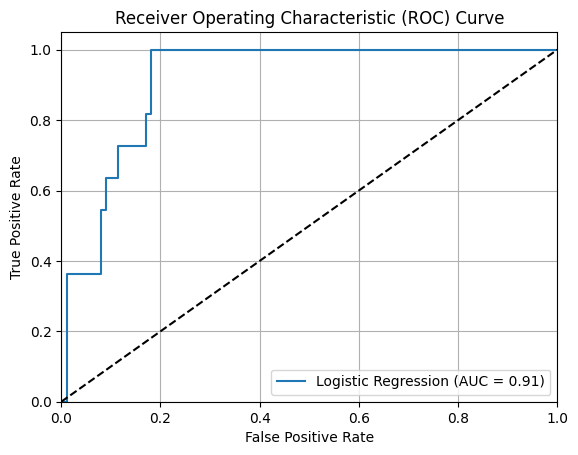

In [5]:
# Phase 4 - Step 4: Plot ROC Curve for Logistic Regression

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [6]:
# Phase 4 - Step 5: Train XGBoost Classifier

from xgboost import XGBClassifier

# Initialize XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train on SMOTE-augmented training set
xgb.fit(X_train_smote, y_train_smote)

# Predict on test set (original test set, no SMOTE)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_prob_xgb))

Confusion Matrix:
[[66 22]
 [ 1 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85        88
           1       0.31      0.91      0.47        11

    accuracy                           0.77        99
   macro avg       0.65      0.83      0.66        99
weighted avg       0.91      0.77      0.81        99


ROC AUC Score:
0.9090909090909091


In [9]:
# Phase 4 - Step 6: Hyperparameter Tuning with Optuna for XGBoost

import optuna
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }
    
    model = XGBClassifier(
        **params,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # 3-fold cross validation
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=3, scoring='roc_auc')
    return scores.mean()

# Create study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Best params
print("Best Hyperparameters:", study.best_params)


[I 2025-04-27 16:47:22,252] A new study created in memory with name: no-name-067ea3f9-596a-4a54-8020-5049385f5685
[I 2025-04-27 16:47:22,352] Trial 0 finished with value: 0.9033632967998759 and parameters: {'n_estimators': 209, 'max_depth': 2, 'learning_rate': 0.29071299060128253, 'subsample': 0.7143467156203027, 'colsample_bytree': 0.9617228999666836, 'gamma': 2.213072471723876, 'reg_alpha': 0.3672747432692567, 'reg_lambda': 0.6794146108556722}. Best is trial 0 with value: 0.9033632967998759.
[I 2025-04-27 16:47:22,445] Trial 1 finished with value: 0.9001097511589032 and parameters: {'n_estimators': 185, 'max_depth': 10, 'learning_rate': 0.09263915887154525, 'subsample': 0.7429202858757705, 'colsample_bytree': 0.6593859242011479, 'gamma': 3.8425115526690212, 'reg_alpha': 0.0014261675359703574, 'reg_lambda': 0.8280125505581003}. Best is trial 0 with value: 0.9033632967998759.
[I 2025-04-27 16:47:22,536] Trial 2 finished with value: 0.9093937944820693 and parameters: {'n_estimators': 11

[I 2025-04-27 16:47:25,146] Trial 21 finished with value: 0.9152677971359148 and parameters: {'n_estimators': 59, 'max_depth': 9, 'learning_rate': 0.15809854497327608, 'subsample': 0.9540291149810972, 'colsample_bytree': 0.50292773865761, 'gamma': 0.42102709693555135, 'reg_alpha': 0.9693182908694606, 'reg_lambda': 0.4389043249937378}. Best is trial 14 with value: 0.9199576935670096.
[I 2025-04-27 16:47:25,210] Trial 22 finished with value: 0.9093322950593669 and parameters: {'n_estimators': 72, 'max_depth': 7, 'learning_rate': 0.18153257811909423, 'subsample': 0.9800692879649338, 'colsample_bytree': 0.5611397889752534, 'gamma': 1.09530693900812, 'reg_alpha': 0.9076985204796847, 'reg_lambda': 0.5265866642236843}. Best is trial 14 with value: 0.9199576935670096.
[I 2025-04-27 16:47:25,333] Trial 23 finished with value: 0.9138588033569421 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.14374734833206554, 'subsample': 0.8885479261926695, 'colsample_bytree': 0.55524

Best Hyperparameters: {'n_estimators': 152, 'max_depth': 3, 'learning_rate': 0.14585294462704523, 'subsample': 0.988325272958448, 'colsample_bytree': 0.5083350543151199, 'gamma': 0.04887522179059901, 'reg_alpha': 0.8196127778533473, 'reg_lambda': 0.6657135685252866}


In [10]:
# Phase 4 - Step 7: Train Tuned XGBoost Classifier

# Rebuild model with best params
xgb_tuned = XGBClassifier(
    n_estimators=152,
    max_depth=3,
    learning_rate=0.14585294462704523,
    subsample=0.988325272958448,
    colsample_bytree=0.5083350543151199,
    gamma=0.04887522179059901,
    reg_alpha=0.8196127778533473,
    reg_lambda=0.6657135685252866,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train on SMOTE-augmented training set
xgb_tuned.fit(X_train_smote, y_train_smote)

# Predict on test set (original test set, no SMOTE)
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
y_prob_xgb_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_tuned))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_tuned))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_prob_xgb_tuned))

Confusion Matrix:
[[69 19]
 [ 2  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87        88
           1       0.32      0.82      0.46        11

    accuracy                           0.79        99
   macro avg       0.65      0.80      0.66        99
weighted avg       0.90      0.79      0.82        99


ROC AUC Score:
0.8894628099173554


In [11]:
# Phase 4 - Step 8: Build Voting Classifier (Logistic + Tuned XGBoost)

from sklearn.ensemble import VotingClassifier

# Create Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('xgb_tuned', xgb_tuned)
    ],
    voting='soft'  # Use predicted probabilities to average
)

# Train on SMOTE-augmented training set
voting_clf.fit(X_train_smote, y_train_smote)

# Predict on test set (original test set, no SMOTE)
y_pred_vote = voting_clf.predict(X_test)
y_prob_vote = voting_clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_vote))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_vote))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_prob_vote))

Confusion Matrix:
[[68 20]
 [ 0 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        88
           1       0.35      1.00      0.52        11

    accuracy                           0.80        99
   macro avg       0.68      0.89      0.70        99
weighted avg       0.93      0.80      0.83        99


ROC AUC Score:
0.9266528925619835


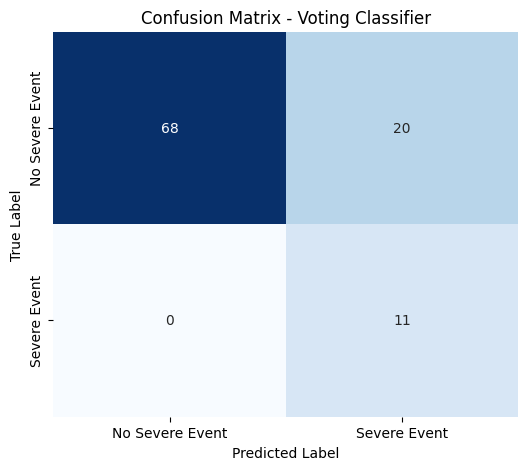

In [12]:
# Phase 5 - Step 1: Confusion Matrix Plot for Voting Classifier

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_vote)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['No Severe Event', 'Severe Event'])
plt.yticks([0.5, 1.5], ['No Severe Event', 'Severe Event'])
plt.show()

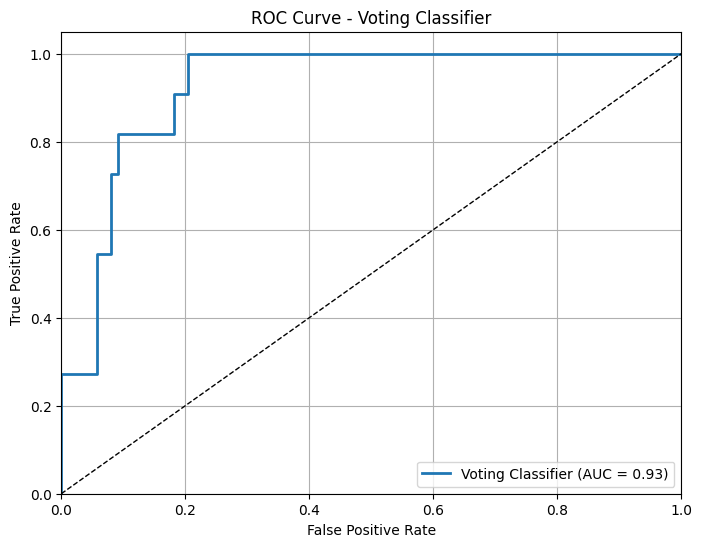

In [13]:
# Phase 5 - Step 2: ROC Curve for Voting Classifier

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_vote)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Voting Classifier (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Voting Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

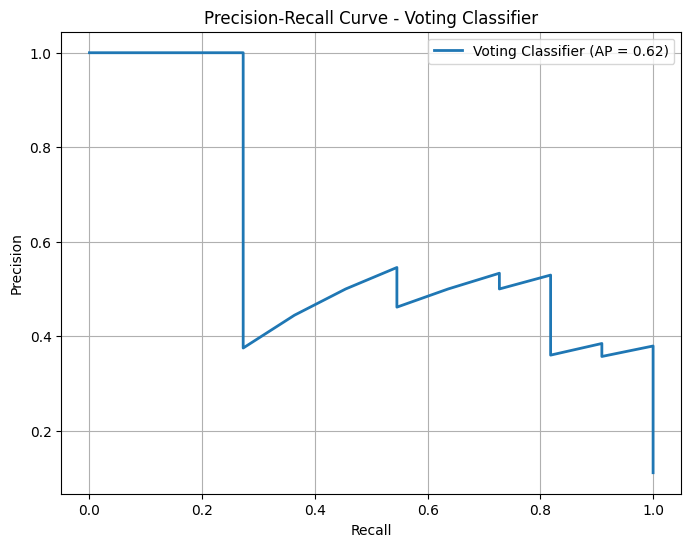

In [14]:
# Phase 5 - Step 3: Precision-Recall Curve for Voting Classifier

from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_vote)
avg_precision = average_precision_score(y_test, y_prob_vote)

# Plot
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Voting Classifier (AP = {avg_precision:.2f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Voting Classifier')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [15]:
# Phase 5 - Save Models to Disk

import pickle
import os

# Define your model save path
save_path = '/Users/shubhmehta/Desktop/programming/Data Science Projects/Chronic kidney disease EHRs Abu Dhabi/models'

# Make sure the path exists (if not, create it)
os.makedirs(save_path, exist_ok=True)

# Save Logistic Regression
with open(os.path.join(save_path, 'logreg_model.pkl'), 'wb') as file:
    pickle.dump(logreg, file)

# Save Tuned XGBoost
with open(os.path.join(save_path, 'xgb_tuned_model.pkl'), 'wb') as file:
    pickle.dump(xgb_tuned, file)

# Save Voting Classifier (Final model)
with open(os.path.join(save_path, 'voting_classifier_model.pkl'), 'wb') as file:
    pickle.dump(voting_clf, file)

print("✅ Models saved successfully!")

✅ Models saved successfully!


PHASE 6

In [16]:
# Install SHAP if not already installed
!pip install shap

# Import libraries
import shap
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

# Load Voting Classifier from saved model
model_path = '/Users/shubhmehta/Desktop/programming/Data Science Projects/Chronic kidney disease EHRs Abu Dhabi/models/voting_classifier_model.pkl'

with open(model_path, 'rb') as file:
    voting_clf = pickle.load(file)

print("✅ Final Voting Classifier model loaded successfully!")

# Now create the SHAP explainer
explainer = shap.Explainer(voting_clf.predict_proba, X_test)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

print("✅ SHAP values calculated successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.4/546.4 kB 9.6 MB/s eta 0:00:00
✅ Final Voting Classifier model loaded successfully!
✅ SHAP values calculated successfully!


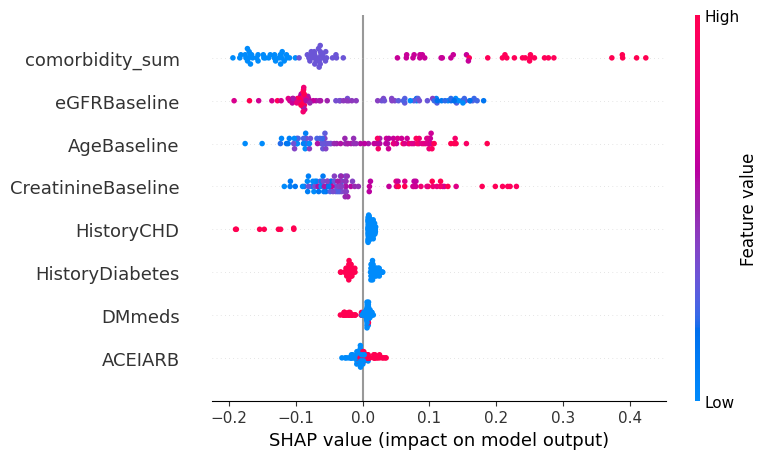

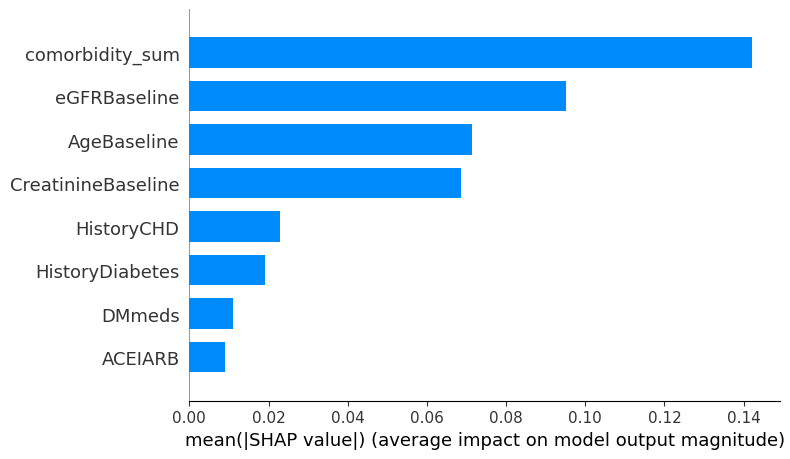

In [17]:
# Phase 6 - Global Interpretability: SHAP Summary Plot

# Summary plot (dot plot showing feature importance + distribution)
shap.summary_plot(shap_values.values[:,:,1], X_test, plot_type="dot", show=True)

# Bar plot (simplified version just showing feature importance magnitudes)
shap.summary_plot(shap_values.values[:,:,1], X_test, plot_type="bar", show=True)

In [20]:
# Phase 6 - Local Interpretability: SHAP Force Plot

# Initialize SHAP Javascript visualizations
shap.initjs()

# Now re-run the force plot
shap.plots.force(shap_values[0, :, 1])

# Pick an index — you can change the index number if you want
patient_idx = 0  # 0th patient in X_test

# Generate a force plot for this patient
shap.plots.force(shap_values[patient_idx, :, 1])

# (Optional) Save the force plot as HTML
# shap.save_html("/path/to/save/force_plot_patient0.html", shap.force_plot(explainer.expected_value[1], shap_values.values[patient_idx,:,1], X_test.iloc[patient_idx,:]))

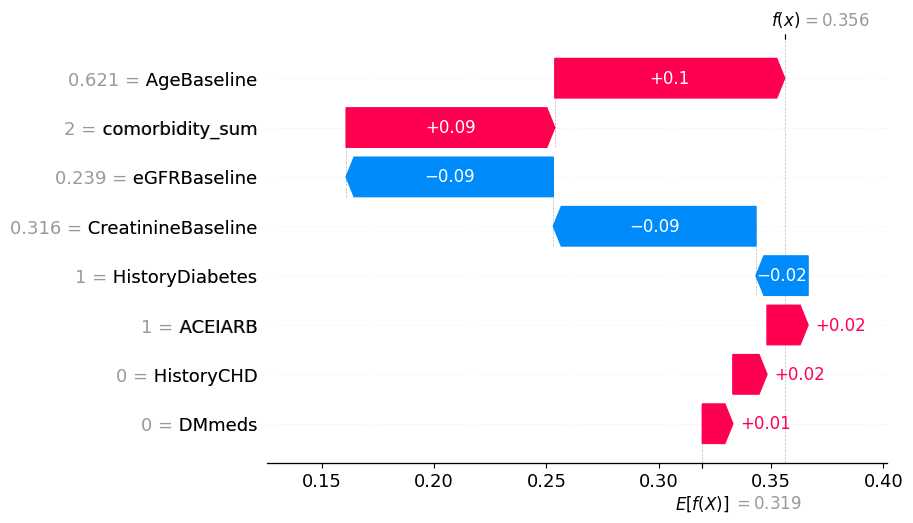

In [21]:
# Phase 6 - SHAP Waterfall Plot

# Waterfall plot for the same patient
shap.plots.waterfall(shap_values[0, :, 1])